In [1]:
import numpy as np
from numpy.linalg import eig
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import scipy
import gzip
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from math import sqrt

In [3]:
class Data:

    _images_file = None
    _labels_file = None

    def __init__(self):
        self._cur = 0
        if not self._images_file or not self._labels_file:
            raise Exception(f"Invalid files: {self._images_file} & {self._labels_file}")
        self._images_fh = gzip.open(self._images_file, 'r')
        self._labels_fh = gzip.open(self._labels_file, 'r')
        _, iimages, self.rows, self.cols = [
            int.from_bytes(self._images_fh.read(4), byteorder='big') for _ in range(4)

        ]

        _, limages = [
            int.from_bytes(self._labels_fh.read(4), byteorder='big') for _ in range(2)

        ]

        assert iimages == limages
        self.images = iimages

        

    def __len__(self):

        return self.images

    

    def __getitem__(self, slices):
        rest = tuple()
        if type(slices) == tuple:
            slices, *rest = slices
        if type(slices) == int:
            slices = [slices]
        elif type(slices) == slice:
            slices = range(*slices.indices(len(self)))
      
        ibuf, lbuf = b'', b''
        ifh, lfh = self._images_fh, self._labels_fh
        for image in slices:

            if image - self._cur != 0:

                ifh.seek(self.rows * self.cols * (image - self._cur), 1)

                lfh.seek(image - self._cur, 1)

            ibuf += ifh.read(self.rows * self.cols)

            lbuf += lfh.read(1)

            self._cur = image + 1

        

        X = np.frombuffer(ibuf, dtype=np.uint8) \
              .reshape(len(slices), self.rows, self.cols)

        

        y = np.frombuffer(lbuf, dtype=np.uint8)

        

        return X[rest], y

    

class TrainData(Data):

    _images_file = 'train-images-idx3-ubyte.gz'

    _labels_file = 'train-labels-idx1-ubyte.gz'
  
     
  
    
class TestData(Data):

    _images_file = 't10k-images-idx3-ubyte.gz'

    _labels_file = 't10k-labels-idx1-ubyte.gz'

    
#create an array of tpoints number of images    
def arrayMake (tpoints, boole):
    if boole == 0:
        train_data=TrainData()
        x,y=train_data[0:tpoints]
        x1=x.reshape((tpoints,784))/255
        y1=y.reshape((tpoints,1))

    else:
        test_data = TestData()
        x,y=test_data[0:5000]
        x1=x.reshape((5000,784))/255
        y1=y.reshape((5000,1))
        
   
    
    return x1, y1
    

#create eigen number of eigenvectors
def evect (eigen, x1):
    x1avg=np.mean(x1, axis=0)
    x1s=x1-x1avg
    XtX=np.matmul(np.transpose(x1s),x1s)
    
    evalues, evectors = eig(XtX)
    idx=evalues.argsort()[::-1]
    evalues=evalues[idx]
    evectors=evectors[:,idx]
    evectors=evectors[:,0:eigen]
    print(np.sum(evalues[0:eigen])/np.trace(XtX))
        
    return evectors

#reconstruct the data
def reconst (evectors, x1):
    xr=np.transpose(x1)
    xrs=np.subtract(xr,np.mean(xr,axis=1)[:,None])
    espace=np.matmul(np.transpose(evectors),xrs)
    recont=np.matmul(np.transpose(espace),np.transpose(evectors))
        
    return recont, espace

def PCA_KNN(eigen,tpoints):
    x1, y1=arrayMake(tpoints)
    pca=PCA(n_components=eigen)
    x1_proj = pca.fit_transform(x1)
    
    test_data=TestData()

    c,d=test_data[0:1000]
    print(c.shape)
    c1=c.reshape((1000,784))/255
    d1=d.reshape((1000,))

    c1_proj = pca.transform(c1)
    
    neigh = KNeighborsClassifier(n_neighbors=5)
    neigh.fit(x1_proj, y1)
    print(x1_proj)
    pred=neigh.predict(c1_proj)
    acc=accuracy_score(d1,pred)
    
    return acc
    
   
    #plot images

def imgplts (data, boole):
    
    if boole ==0:
    
        for i in range (25):
            plt.subplot(5, 5, i+1)
            plt.imshow(np.abs(data[i,:].reshape(28,28)),cmap='gray')
        
    else:
        
        for i in range (25):
            plt.subplot(5, 5, i+1)
            plt.imshow(np.abs(data[:,i].reshape(28,28)))

    return 
                   

def classifier (espace, c1espace, y1):
    neigh = KNeighborsClassifier(n_neighbors=3)
    neigh.fit(np.real(np.transpose(espace)), y1.flatten())
    pred=neigh.predict(np.real(np.transpose(c1espace)))

    return pred

def accuracy (pred, d1):
    acc=accuracy_score(d1,pred.flatten())
    
    return acc


def accS2F (eigen, tpoints):
    x1, y1 = arrayMake(tpoints, 0)
    c1, d1 = arrayMake(tpoints, 1)

    evectors=evect(eigen, x1)
    x1espace=reconst(evectors, x1)[1]
    c1espace=reconst(evectors, c1)[1]

    pred=classifier(x1espace,c1espace,y1)
    acc=accuracy(pred, d1)    
    
    return acc

    


In [ ]:
x1=arrayMake(3000,1)[0]
evec=evect(25,x1)
recont=reconst(evec, x1)[0]
imgplts(recont,0)

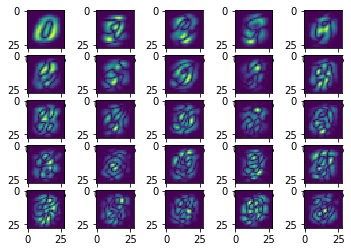

In [103]:
x1=arrayMake(3000,0)[0]
evec=evect(25,x1)
imgplts(evec,1)

In [ ]:
accTpoints=np.zeros((15,2))
accEigen=np.zeros((15,2))

for i in range (15):
    accTpoints[i,0]=(i+1)*1000
    accTpoints[i,1]=accS2F(25,int(accTpoints[i,0]))
    
    accEigen[i,0]=(i+1)*5
    accEigen[i,1]=accS2F(int(accEigen[i,0]),3000)

    
plt.figure(figsize=(20,20))
    
plt.plot(accTpoints[:,0], (accTpoints[:,1]))
plt.plot(accEigen[:,0], (accEigen[:,1]))


Text(0.5, 1.0, 'Accuracy vs. Number of Eigenvectors')

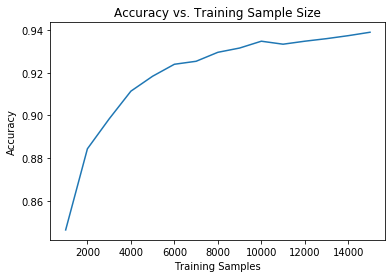

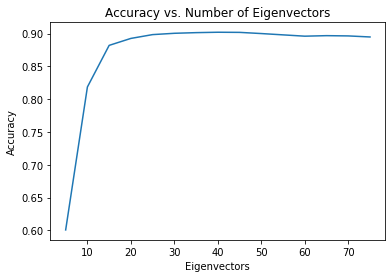

In [130]:
plt.figure()
plt.plot(accTpoints[:,0], (accTpoints[:,1]))
plt.xlabel('Training Samples')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Training Sample Size')

plt.figure()
plt.plot(accEigen[:,0], (accEigen[:,1]))
plt.xlabel('Eigenvectors')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Eigenvectors')





In [40]:
print(accS2F(784,7000))

0.9265714285714286


In [131]:

print(accS2F(25,3000))

(0.7022623562585507+0j)
0.8984
